# Quantized FACILE Training with Brevitas
This notebook walks through the steps to train and and validate the Pytorch Brevitas reconstruction of the HCAL Facile model

Initial Pytorch conversion by Vladimir Oveckhin
Pytorch to Brevitas conversion by Matthew Trahms

In [1]:
#install pandas (missing in FINN env)
!pip install --user pandas

In [1]:
#import the necessary classes and functions
from train import train
from metrics import Metrics
from quant_model import QuantNet

In [2]:
models_folder = 'quant_models'

X_train shape: (229538, 14)
X_val shape: (12752, 14)
X_test shape: (12752, 14)
Y_train shape: (229538, 1)
Y_val shape: (12752, 1)
Y_test shape: (12752, 1)
Using saved split data
Number of batches per epoch: 460
# of Model parameters: 339.0
# of features: 14


Epoch 1
Ave Train Loss: 4.271809356136107
Ave Val Loss: 212.09260873945934
Min Ave Val Loss: 212.09260873945934
Saved model


Epoch 2
Ave Train Loss: 4.204363662571751
Ave Val Loss: 210.42081124441964
Min Ave Val Loss: 210.42081124441964
Saved model


Epoch 3
Ave Train Loss: 4.169785886189392
Ave Val Loss: 207.10305543929812
Min Ave Val Loss: 207.10305543929812
Saved model


Epoch 4
Ave Train Loss: 4.120866561841918
Ave Val Loss: 204.10719032893104
Min Ave Val Loss: 204.10719032893104
Saved model


Epoch 5
Ave Train Loss: 4.073556005704938
Ave Val Loss: 202.36554730127727
Min Ave Val Loss: 202.36554730127727
Saved model


Epoch 6
Ave Train Loss: 4.038201481987562
Ave Val Loss: 200.23188127790178
Min Ave Val Loss: 200.2318812779017

Ave Train Loss: 2.5375298091557146
Ave Val Loss: 126.87961856902592
Min Ave Val Loss: 126.87961856902592
Saved model


Epoch 53
Ave Train Loss: 2.5138928300938495
Ave Val Loss: 125.79396008688306
Min Ave Val Loss: 125.79396008688306
Saved model


Epoch 54
Ave Train Loss: 2.490445815503843
Ave Val Loss: 126.36651466006325
Min Ave Val Loss: 125.79396008688306


Epoch 55
Ave Train Loss: 2.4672199152844008
Ave Val Loss: 123.13048105391245
Min Ave Val Loss: 123.13048105391245
Saved model


Epoch 56
Ave Train Loss: 2.44783084993263
Ave Val Loss: 123.01729063003782
Min Ave Val Loss: 123.01729063003782
Saved model


Epoch 57
Ave Train Loss: 2.4229425174813612
Ave Val Loss: 120.03795103042845
Min Ave Val Loss: 120.03795103042845
Saved model


Epoch 58
Ave Train Loss: 2.397685522188439
Ave Val Loss: 119.03054470486111
Min Ave Val Loss: 119.03054470486111
Saved model


Epoch 59
Ave Train Loss: 2.376571517933833
Ave Val Loss: 118.83209107414125
Min Ave Val Loss: 118.83209107414125
Saved model


Ep

Ave Train Loss: 1.6651506668166736
Ave Val Loss: 82.76449318537637
Min Ave Val Loss: 82.76449318537637
Saved model


Epoch 106
Ave Train Loss: 1.6526264589895996
Ave Val Loss: 83.05399286179315
Min Ave Val Loss: 82.76449318537637


Epoch 107
Ave Train Loss: 1.6424040561581597
Ave Val Loss: 82.07083868601966
Min Ave Val Loss: 82.07083868601966
Saved model


Epoch 108
Ave Train Loss: 1.632048163086482
Ave Val Loss: 81.49801914275639
Min Ave Val Loss: 81.49801914275639
Saved model


Epoch 109
Ave Train Loss: 1.6237558873194216
Ave Val Loss: 81.1596200125558
Min Ave Val Loss: 81.1596200125558
Saved model


Epoch 110
Ave Train Loss: 1.6212935793908665
Ave Val Loss: 80.52842785063244
Min Ave Val Loss: 80.52842785063244
Saved model


Epoch 111
Ave Train Loss: 1.6032628434137863
Ave Val Loss: 80.5891591632177
Min Ave Val Loss: 80.52842785063244


Epoch 112
Ave Train Loss: 1.5859354442601121
Ave Val Loss: 81.1363034929548
Min Ave Val Loss: 80.52842785063244


Epoch 113
Ave Train Loss: 1.5795743

Ave Train Loss: 1.24578059376398
Ave Val Loss: 63.46649957081628
Min Ave Val Loss: 63.23418087429471


Epoch 160
Ave Train Loss: 1.2407747554241428
Ave Val Loss: 63.06160832965185
Min Ave Val Loss: 63.06160832965185
Saved model


Epoch 161
Ave Train Loss: 1.2324413838714885
Ave Val Loss: 62.86543516128782
Min Ave Val Loss: 62.86543516128782
Saved model


Epoch 162
Ave Train Loss: 1.2301303880244128
Ave Val Loss: 61.4157228015718
Min Ave Val Loss: 61.4157228015718
Saved model


Epoch 163
Ave Train Loss: 1.2271470629605634
Ave Val Loss: 61.355628119574654
Min Ave Val Loss: 61.355628119574654
Saved model


Epoch 164
Ave Train Loss: 1.222343916339135
Ave Val Loss: 62.165762886168466
Min Ave Val Loss: 61.355628119574654


Epoch 165
Ave Train Loss: 1.216349087395158
Ave Val Loss: 61.614866831945996
Min Ave Val Loss: 61.355628119574654


Epoch 166
Ave Train Loss: 1.2116135481552295
Ave Val Loss: 60.5855223640563
Min Ave Val Loss: 60.5855223640563
Saved model


Epoch 167
Ave Train Loss: 1.1865

Ave Train Loss: 0.9798036988516148
Ave Val Loss: 49.603958977593315
Min Ave Val Loss: 48.8187749953497


Epoch 214
Ave Train Loss: 0.9813115045705216
Ave Val Loss: 51.29359641907707
Min Ave Val Loss: 48.8187749953497


Epoch 215
Ave Train Loss: 0.9746491411308139
Ave Val Loss: 49.849625723702566
Min Ave Val Loss: 48.8187749953497


Epoch 216
Ave Train Loss: 0.9724389292870182
Ave Val Loss: 48.90091911194816
Min Ave Val Loss: 48.8187749953497


Epoch 217
Ave Train Loss: 0.9663151708280048
Ave Val Loss: 48.9468138558524
Min Ave Val Loss: 48.8187749953497


Epoch 218
Ave Train Loss: 0.9651830228309913
Ave Val Loss: 49.33662354000031
Min Ave Val Loss: 48.8187749953497


Epoch 219
Ave Train Loss: 0.969269602723498
Ave Val Loss: 47.87427254328652
Min Ave Val Loss: 47.87427254328652
Saved model


Epoch 220
Ave Train Loss: 0.9561605341894472
Ave Val Loss: 47.87819586859809
Min Ave Val Loss: 47.87427254328652


Epoch 221
Ave Train Loss: 0.9631966282091594
Ave Val Loss: 49.15781475248791
Min Ave

Ave Train Loss: 0.8131836625261641
Ave Val Loss: 40.12714652409629
Min Ave Val Loss: 39.94523445008293


Epoch 269
Ave Train Loss: 0.8086385539549228
Ave Val Loss: 40.7260620480492
Min Ave Val Loss: 39.94523445008293


Epoch 270
Ave Train Loss: 0.7996075816345972
Ave Val Loss: 39.94096822587271
Min Ave Val Loss: 39.94096822587271
Saved model


Epoch 271
Ave Train Loss: 0.7959788185948387
Ave Val Loss: 41.732205224415615
Min Ave Val Loss: 39.94096822587271


Epoch 272
Ave Train Loss: 0.8053356232776204
Ave Val Loss: 40.72825804210844
Min Ave Val Loss: 39.94096822587271


Epoch 273
Ave Train Loss: 0.8022787293893484
Ave Val Loss: 40.1084718250093
Min Ave Val Loss: 39.94096822587271


Epoch 274
Ave Train Loss: 0.7966403712394868
Ave Val Loss: 39.59260486421131
Min Ave Val Loss: 39.59260486421131
Saved model


Epoch 275
Ave Train Loss: 0.795903268782893
Ave Val Loss: 39.47893675546798
Min Ave Val Loss: 39.47893675546798
Saved model


Epoch 276
Ave Train Loss: 0.7954222959808551
Ave Val Los

Ave Train Loss: 0.7460489033674265
Ave Val Loss: 37.44014164758107
Min Ave Val Loss: 36.29803618173751


Epoch 325
Ave Train Loss: 0.7405111398304607
Ave Val Loss: 37.986193460131446
Min Ave Val Loss: 36.29803618173751


Epoch 326
Ave Train Loss: 0.7390914304880338
Ave Val Loss: 39.989398895748074
Min Ave Val Loss: 36.29803618173751


Epoch 327
Ave Train Loss: 0.7358534968755513
Ave Val Loss: 36.486446743919736
Min Ave Val Loss: 36.29803618173751


Epoch 328
Ave Train Loss: 0.7293449254743879
Ave Val Loss: 37.98721204485212
Min Ave Val Loss: 36.29803618173751


Epoch 329
Ave Train Loss: 0.7286800076105658
Ave Val Loss: 38.41404366871667
Min Ave Val Loss: 36.29803618173751


Epoch 330
Ave Train Loss: 0.7283406756823293
Ave Val Loss: 37.239010462685236
Min Ave Val Loss: 36.29803618173751


Epoch 331
Ave Train Loss: 0.7319405218217673
Ave Val Loss: 37.61959445287311
Min Ave Val Loss: 36.29803618173751


Epoch 332
Ave Train Loss: 0.7373969531239789
Ave Val Loss: 36.59322659931485
Min Ave V

Ave Train Loss: 0.6947197664630455
Ave Val Loss: 35.4447385394384
Min Ave Val Loss: 34.36663188631572


Epoch 381
Ave Train Loss: 0.690921857268965
Ave Val Loss: 36.1235343085395
Min Ave Val Loss: 34.36663188631572


Epoch 382
Ave Train Loss: 0.6922053921330606
Ave Val Loss: 34.332776750837056
Min Ave Val Loss: 34.332776750837056
Saved model


Epoch 383
Ave Train Loss: 0.6945350191013145
Ave Val Loss: 34.98877788725353
Min Ave Val Loss: 34.332776750837056


Epoch 384
Ave Train Loss: 0.6908154957221901
Ave Val Loss: 35.19871629987444
Min Ave Val Loss: 34.332776750837056


Epoch 385
Ave Train Loss: 0.6953228148291946
Ave Val Loss: 37.606560177273224
Min Ave Val Loss: 34.332776750837056


Epoch 386
Ave Train Loss: 0.6952265916175916
Ave Val Loss: 36.22436051141648
Min Ave Val Loss: 34.332776750837056


Epoch 387
Ave Train Loss: 0.7035419206948569
Ave Val Loss: 37.8317757863847
Min Ave Val Loss: 34.332776750837056


Epoch 388
Ave Train Loss: 0.6977908627688119
Ave Val Loss: 35.454348791213

Ave Train Loss: 0.684326173337474
Ave Val Loss: 35.92948193020291
Min Ave Val Loss: 33.37635312761579


Epoch 437
Ave Train Loss: 0.681036409180734
Ave Val Loss: 33.51188302418542
Min Ave Val Loss: 33.37635312761579


Epoch 438
Ave Train Loss: 0.6849475513557268
Ave Val Loss: 33.76864593748062
Min Ave Val Loss: 33.37635312761579


Epoch 439
Ave Train Loss: 0.683162139617899
Ave Val Loss: 36.55944273206923
Min Ave Val Loss: 33.37635312761579


Epoch 440
Ave Train Loss: 0.6815599015532908
Ave Val Loss: 35.093536255851625
Min Ave Val Loss: 33.37635312761579


Epoch 441
Ave Train Loss: 0.6840386068069254
Ave Val Loss: 33.59535647195483
Min Ave Val Loss: 33.37635312761579


Epoch 442
Ave Train Loss: 0.6805214381124267
Ave Val Loss: 33.528848738897416
Min Ave Val Loss: 33.37635312761579


Epoch 443
Ave Train Loss: 0.6818395244568242
Ave Val Loss: 33.89014598301479
Min Ave Val Loss: 33.37635312761579


Epoch 444
Ave Train Loss: 0.678991367622711
Ave Val Loss: 34.380436064705016
Min Ave Val Lo

Ave Train Loss: 0.6638592964156874
Ave Val Loss: 34.95940532381572
Min Ave Val Loss: 31.919260903010294


Epoch 493
Ave Train Loss: 0.6521155639028349
Ave Val Loss: 33.80744673713805
Min Ave Val Loss: 31.919260903010294


Epoch 494
Ave Train Loss: 0.659860342448362
Ave Val Loss: 35.53318332490467
Min Ave Val Loss: 31.919260903010294


Epoch 495
Ave Train Loss: 0.6650954128866624
Ave Val Loss: 36.22492744809105
Min Ave Val Loss: 31.919260903010294


Epoch 496
Ave Train Loss: 0.6734094097165804
Ave Val Loss: 35.49896028306749
Min Ave Val Loss: 31.919260903010294


Epoch 497
Ave Train Loss: 0.6687088264639699
Ave Val Loss: 34.247486962212456
Min Ave Val Loss: 31.919260903010294


Epoch 498
Ave Train Loss: 0.6648253346868049
Ave Val Loss: 34.322608221144904
Min Ave Val Loss: 31.919260903010294


Epoch 499
Ave Train Loss: 0.6740629957999619
Ave Val Loss: 33.36421034071181
Min Ave Val Loss: 31.919260903010294


Epoch 500
Ave Train Loss: 0.6785559234979441
Ave Val Loss: 34.053189656091114
Min

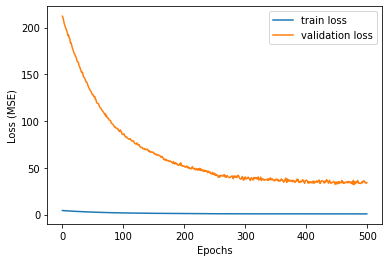

In [3]:
#train (mimicing structure in train.py)
metrics = Metrics()
model = None
try:
    model = train(QuantNet, metrics=metrics, models_folder_path=models_folder, quantized=True)
except KeyboardInterrupt:
    print("Interrupted")
finally:
    metrics.plot_losses()

In [5]:
#export to onnx finn format
from brevitas.onnx import export_finn_onnx
input_shape = [1,14]
export_finn_onnx(model, input_shape, models_folder + "/facile.onnx")